In [2]:
import pandas as pd
import numpy as np
import nmslib

%load_ext autoreload
%autoreload 2
from matrix_factorization import Matrix_Factorization_V2

from itertools import product
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import preprocessing
from sklearn.gaussian_process import GaussianProcessRegressor
import sklearn.gaussian_process.kernels as k
# init value: set -200 as out of range value
OUT_OF_RANGE_RSSI = -100.

# VBD DATA

In [3]:
beacons = ['Beacon00001', 'Beacon00002', 'Beacon00003', 'Beacon00004', 'Beacon00005', 'Beacon00006']
def preprocess_data(raw_data='training-vbd-floor1.json', beacons=beacons):
    rawdata_vbd_df = pd.read_json('training-vbd-floor1.json')
    data = []
    row_data = []
    for cell in rawdata_vbd_df.data.beacons:
        row_data = []
        row_data.append(cell['Y'])
        row_data.append(cell['X'])
        for beacon in beacons:
            row_data.append(int(cell[beacon]))
        data.append(row_data)
    columns = ['col', 'row'] + beacons
    # convert to dataframe
    rssi_dataset_df = pd.DataFrame(data, columns=columns)
    return rssi_dataset_df

# convert to dataframe
rssi_dataset_df = preprocess_data()

## Split train set & test set

In [4]:
training_data = rssi_dataset_df.sample(frac=0.9, random_state=10)
testing_data = rssi_dataset_df.drop(training_data.index)

print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")

No. of training examples: 72
No. of testing examples: 8


# Gaussian Processes Regression

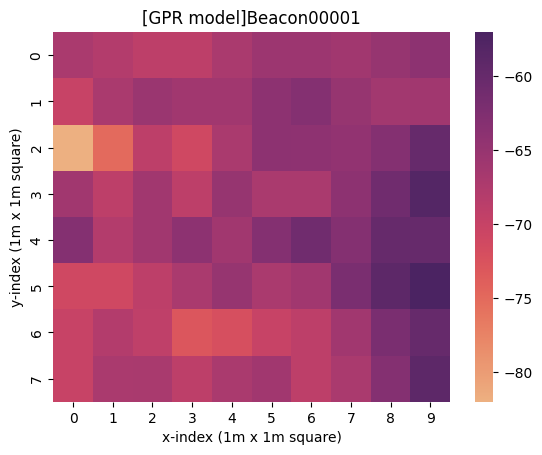

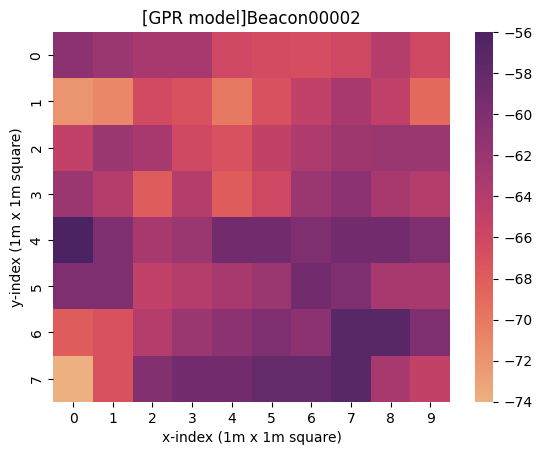

c:\anaconda\envs\radiomap\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


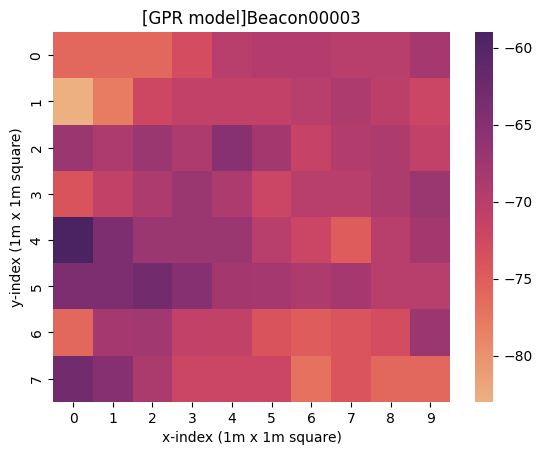

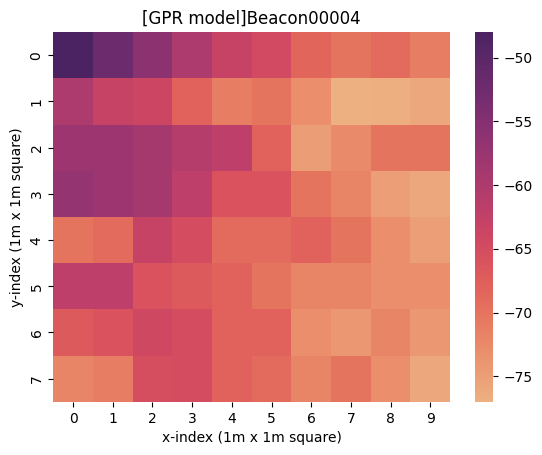

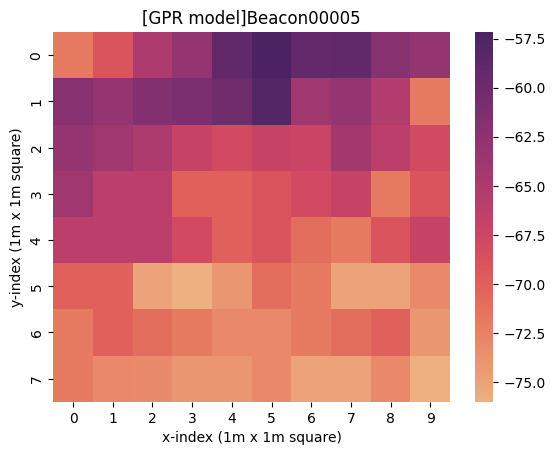

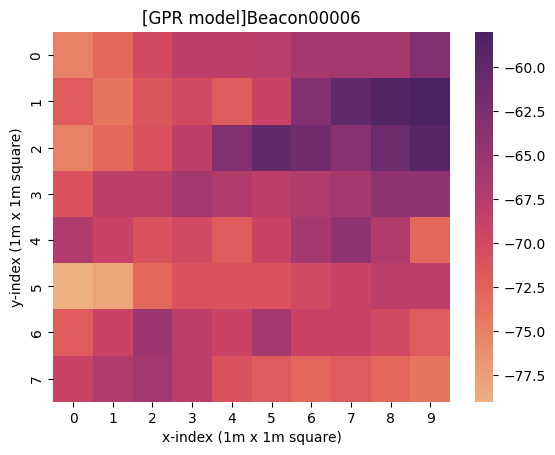

In [18]:
from helper import plot_radiomap

# init test matrix
n_rows = 8
n_cols = 10
radiomap = np.full((n_rows, n_cols), OUT_OF_RANGE_RSSI)
radiomaps = []
radiomaps_test = []
for beacon in beacons:
    # sample inputs and outputs
    X = training_data[['row', 'col']].to_numpy()
    Y = training_data[[beacon]].to_numpy()

    # standardscale
    X_scaler = preprocessing.StandardScaler().fit(X)
    Y_scaler = preprocessing.StandardScaler().fit(Y)
    # transform
    X_scaled = X_scaler.transform(X)
    Y_scaled = Y_scaler.transform(Y)

    # init kernel
    kernel = k.RBF(length_scale=[1., 1.], length_scale_bounds=(1e-2,1e2))
    # run GPR
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100, normalize_y=True)
    gp.fit(X_scaled, Y_scaled.reshape(-1,1))

    # PLOT
    for i in range(n_rows):
        for j in range(n_cols):
            x_pred = X_scaler.transform(np.array([[i,j]]))
            y_mean,y_std = gp.predict(x_pred,return_std=True)
            radiomap[i, j] = Y_scaler.inverse_transform(np.array([y_mean]))
    plot_radiomap(radiomap, min_data=radiomap.min(), max_data=radiomap.max(), beacon=beacon)
    # [END] PLOT

    # add radiomap
    radiomaps.append(radiomap.flatten())


In [9]:
import helper

Test data ({row_idx},{col_idx}): [-64 -63 -71 -77 -69 -56]
3 nearest neighbours (array idx): [18 26 19] [29.526377 38.12723  55.      ]
3 nearest neighbours (matrix idx):
([[1 8]
 [2 6]
 [1 9]])
Centroid cell: ([1.83506271 8.06214777])
Error: 0.5513452566234747


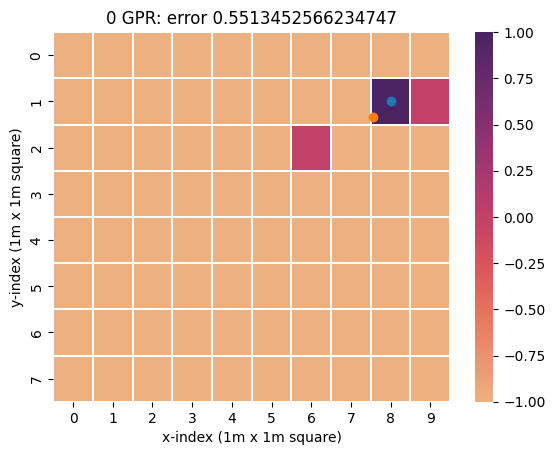

Test data ({row_idx},{col_idx}): [-64 -67 -66 -68 -58 -68]
3 nearest neighbours (array idx): [6 5 7] [20.922163 27.869078 30.      ]
3 nearest neighbours (matrix idx):
([[0 6]
 [0 5]
 [0 7]])
Centroid cell: ([0.5        6.47821797])
Error: 0.9782179686103154


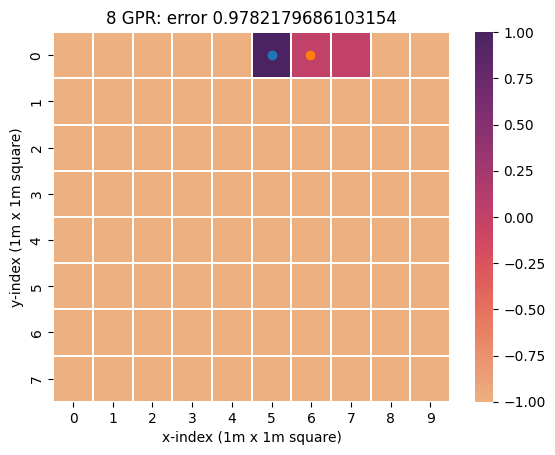

Test data ({row_idx},{col_idx}): [-65 -65 -64 -72 -56 -66]
3 nearest neighbours (array idx): [ 7  6 15] [51.       56.665115 71.      ]
3 nearest neighbours (matrix idx):
([[0 7]
 [0 6]
 [1 5]])
Centroid cell: ([0.77433846 6.60758395])
Error: 0.29467931549909554


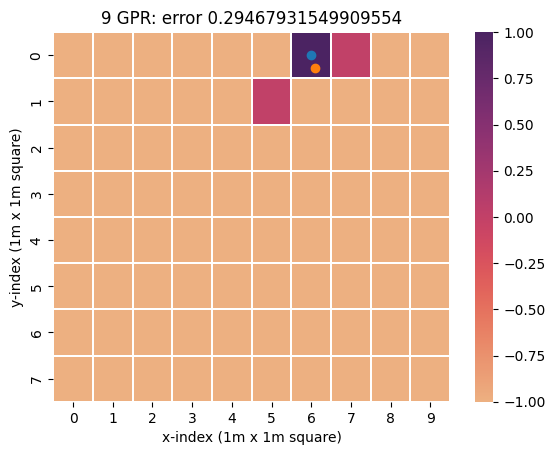

Test data ({row_idx},{col_idx}): [-69 -71 -73 -64 -65 -73]
3 nearest neighbours (array idx): [11 12 13] [35.       49.575462 70.      ]
3 nearest neighbours (matrix idx):
([[1 1]
 [1 2]
 [1 3]])
Centroid cell: ([1.50000004 2.27334493])
Error: 0.22665507126282847


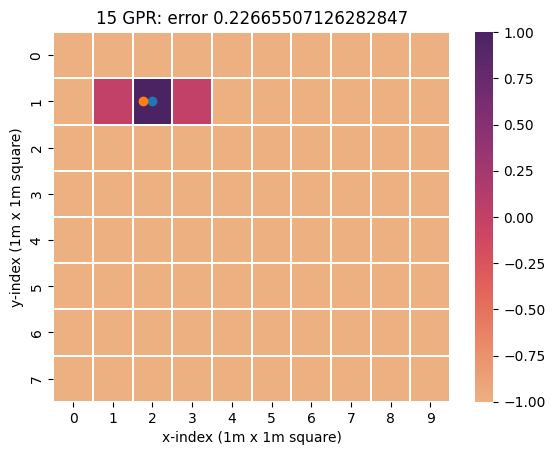

Test data ({row_idx},{col_idx}): [-62 -63 -68 -68 -66 -61]
3 nearest neighbours (array idx): [28 25 29] [ 7. 10. 26.]
3 nearest neighbours (matrix idx):
([[2 8]
 [2 5]
 [2 9]])
Centroid cell: ([2.49999997 7.57031243])
Error: 1.070312426340028


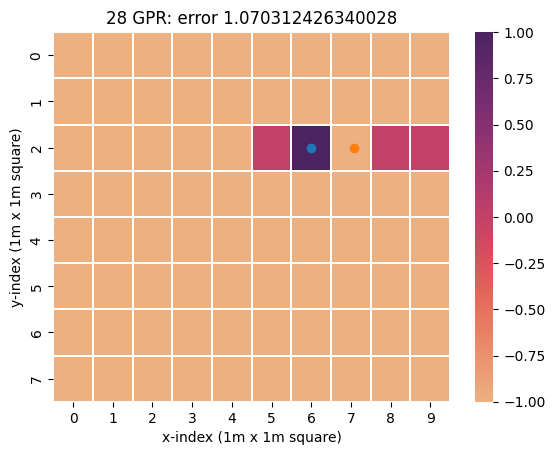

Test data ({row_idx},{col_idx}): [-66 -63 -66 -69 -66 -63]
3 nearest neighbours (array idx): [25 28  9] [23. 24. 30.]
3 nearest neighbours (matrix idx):
([[2 5]
 [2 8]
 [0 9]])
Centroid cell: ([1.93730881 7.68042793])
Error: 0.5909108314454279


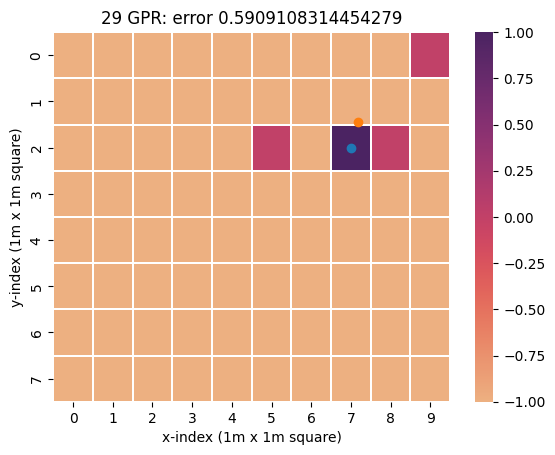

Test data ({row_idx},{col_idx}): [-67 -67 -67 -66 -71 -68]
3 nearest neighbours (array idx): [61 34 62] [ 4.       11.       24.673584]
3 nearest neighbours (matrix idx):
([[6 1]
 [3 4]
 [6 2]])
Centroid cell: ([5.78500304 2.3212508 ])
Error: 0.737001983419782


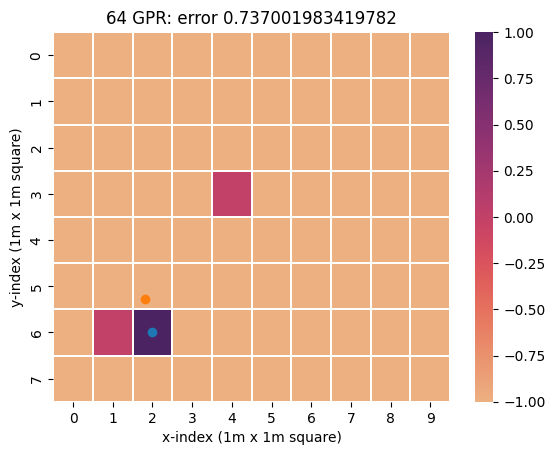

Test data ({row_idx},{col_idx}): [-67 -59 -70 -65 -75 -69]
3 nearest neighbours (array idx): [73 72 74] [10.       17.590973 18.      ]
3 nearest neighbours (matrix idx):
([[7 3]
 [7 2]
 [7 4]])
Centroid cell: ([7.5        3.49391825])
Error: 0.9939182483208184


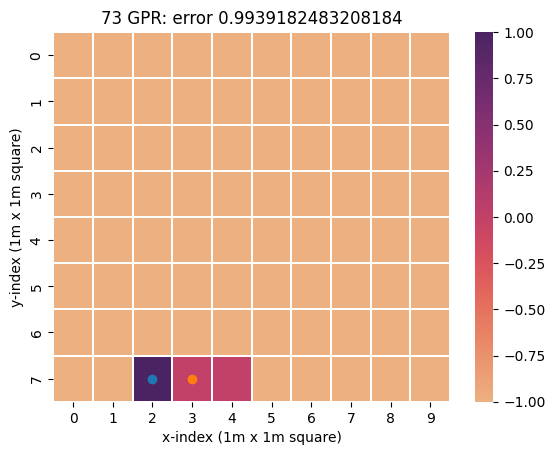

RMSE:  0.7437145046179257


In [11]:
helper.check_position_pred_accuracy(radiomaps=radiomaps, testing_data=testing_data)